In [38]:
using RCall
using DataFrames, DataFramesMeta
using CSV
using DataVoyager
using Statistics
ENV["LINES"] = 10
ENV["COLUMNS"]=10000;

### Load Covid Data

source: https://covid.ourworldindata.org/data/owid-covid-data.csv

In [39]:
df = CSV.read("../data/owid-covid-data.csv",DataFrame)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
,String,String,String,Date…,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String?,Float64?,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,AFG,Asia,Afghanistan,2020-01-23,missing,0.0,missing,missing,0.0,missing,missing,0.0,missing,missing,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.0,3.89283e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-24,missing,0.0,missing,missing,0.0,missing,missing,0.0,missing,missing,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.0,3.89283e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-01-25,missing,0.0,missing,missing,0.0,missing,missing,0.0,missing,missing,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.0,3.89283e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-01-26,missing,0.0,missing,missing,0.0,missing,missing,0.0,missing,missing,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.0,3.89283e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.498
5,AFG,Asia,Afghanistan,2020-01-27,missing,0.0,missing,missing,0.0,missing,missing,0.0,missing,missing,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.0,3.89283e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.498
6,AFG,Asia,Afghanistan,2020-01-28,missing,0.0,0.0,missing,0.0,0.0,missing,0.0,0.0,missing,0.0,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.0,3.89283e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.498
7,AFG,Asia,Afghanistan,2020-01-29,missing,0.0,0.0,missing,0.0,0.0,missing,0.0,0.0,missing,0.0,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.0,3.89283e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.498
8,AFG,Asia,Afghanistan,2020-01-30,missing,0.0,0.0,missing,0.0,0.0,missing,0.0,0.0,missing,0.0,0.0,missing,missing,missi

### Modeling Daily Deaths

In [40]:
@rput df
R"""
library(tidyverse)

sdf = df %>% group_by(location) %>% 
summarise(
   mnewcases = mean(new_cases,na.rm=T),
   mnewdeaths = mean(new_deaths,na.rm=T),
   mpopulation = mean(population,na.rm=T),
   mcardio = mean(cardiovasc_death_rate,na.rm=T),
   mdiab = mean(diabetes_prevalence,na.rm=T),
   mhandwash = mean(handwashing_facilities,na.rm=T),
   mhbed = mean(hospital_beds_per_thousand,na.rm=T),
   mpatient = mean(hosp_patients,na.rm=T),
   madmission = mean(weekly_hosp_admissions,na.rm=T),
   mhdi = mean(human_development_index,na.rm=T),
   mle = mean(life_expectancy,na.rm=T)
) 
""" 

┌ Warning: RCall.jl: `summarise()` ungrouping output (override with `.groups` argument)
└ @ RCall /Users/ppalmes/.julia/packages/RCall/eRsxl/src/io.jl:160


RObject{VecSxp}
# A tibble: 190 x 12
   location mnewcases mnewdeaths mpopulation mcardio mdiab mhandwash  mhbed
   <chr>        <dbl>      <dbl>       <dbl>   <dbl> <dbl>     <dbl>  <dbl>
 1 Afghani…   149.        6.02      38928341    597.  9.59      37.7   0.5 
 2 Albania    150.        3.11       2877800    304. 10.1      NaN     2.89
 3 Algeria    283.        7.98      43851043    278.  6.73      83.7   1.9 
 4 Andorra     22.6       0.242        77265    109.  7.97     NaN   NaN   
 5 Angola      49.8       1.16      32866268    276.  3.94      26.7 NaN   
 6 Antigua…     0.459     0.0153       97928    192. 13.2      NaN     3.8 
 7 Argenti…  4597.      126.        45195777    191.  5.5      NaN     5   
 8 Armenia    455.        7.65       2963234    341.  7.11      94.0   4.2 
 9 Austral…    85.8       2.78      25499881    108.  5.07     NaN     3.84
10 Austria    994.       13.9        9006400    145.  6.35     NaN     7.37
# … with 180 more rows, and 4 more variables: mpati

In [41]:
dfimp = R"""
           library(mice)
           imputed=mice(sdf,meth='sample',printFlag=F)
           complete(imputed)
        """ |> rcopy

┌ Warning: RCall.jl: Warning: Number of logged events: 1
└ @ RCall /Users/ppalmes/.julia/packages/RCall/eRsxl/src/io.jl:160


,location,mnewcases,mnewdeaths,mpopulation,mcardio,mdiab,mhandwash,mhbed,mpatient,madmission,mhdi,mle
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Afghanistan,148.985,6.02141,3.89283e7,597.029,9.59,37.746,0.5,75.6971,342.695,0.498,64.83
2,Albania,150.431,3.10703,2.8778e6,304.195,10.08,15.574,2.89,721.18,13.8108,0.785,78.57
3,Algeria,283.171,7.97859,4.3851e7,278.364,6.73,83.741,1.9,221.842,13.8108,0.754,76.88
4,Andorra,22.5749,0.24159,77265.0,109.135,7.97,41.047,3.4,799.0,14646.8,0.858,83.73
5,Angola,49.7768,1.15596,3.28663e7,276.045,3.94,26.664,2.4,235.535,81.4144,0.581,61.15
6,Antigua and Barbuda,0.458716,0.0152905,97928.0,191.511,13.17,9.831,3.8,73.0,5739.43,0.78,77.02
7,Argentina,4597.01,125.508,4.51958e7,191.032,5.5,20.859,5.0,4.13636,1230.81,0.825,76.67
8,Armenia,454.685,7.65443,2.96323e6,341.01,7.11,94.043,4.2,452.962,124.394,0.755,75.09
9,Australia,85.7737,2.78287,2.54999e7,107.791,5.07,72.704,3.84,5765.1,94.1152,0.939,83.44


In [42]:
X = dfimp[:,Not([:location,:mnewdeaths])]
Y = dfimp.mnewdeaths;

In [43]:
R"""
library(caret)
fitControl <- trainControl(method = "repeatedcv",number = 5)
rfcaret <- train($X,$Y, method = "rf", trControl = fitControl)
rfcaret
"""

RObject{VecSxp}
Random Forest 

190 samples
 10 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 154, 152, 152, 151, 151 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
   2    53.99111  0.6147871  22.20653
   6    47.02932  0.7045796  16.26811
  10    48.04563  0.7676079  14.90999

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 6.


In [44]:
R"""
library(randomForest)
model = randomForest($X,$Y,mtry=10)
"""

RObject{VecSxp}

Call:
 randomForest(x = `#JL`$X, y = `#JL`$Y, mtry = 10) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 10

          Mean of squared residuals: 2747.61
                    % Var explained: 67.56


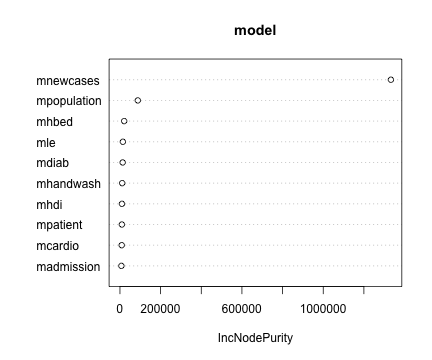

RObject{RealSxp}
            IncNodePurity
mnewcases     1332993.613
mpopulation     87846.069
mcardio          8633.260
mdiab           13379.920
mhandwash       10946.778
mhbed           20695.755
mpatient         9430.529
madmission       7031.363
mhdi             9894.292
mle             14422.210


In [45]:
R"varImpPlot(model)"

### Create model per country using Distributed approach

In [46]:
@rput df
dfcw = R"""
library(tidyverse)
library(mice)
library(lubridate)

dfcm = df %>% group_by(location,week=week(date)) %>% 
summarise(
   mnewcases = mean(new_cases,na.rm=T),
   mnewdeaths = mean(new_deaths,na.rm=T),
   mpopulation = mean(population,na.rm=T),
   mcardio = mean(cardiovasc_death_rate,na.rm=T),
   mdiab = mean(diabetes_prevalence,na.rm=T),
   mhandwash = mean(handwashing_facilities,na.rm=T),
   mhbed = mean(hospital_beds_per_thousand,na.rm=T),
   mpatient = mean(hosp_patients,na.rm=T),
   madmission = mean(weekly_hosp_admissions,na.rm=T),
   mhdi = mean(human_development_index,na.rm=T),
   mle = mean(life_expectancy,na.rm=T)
) 
imp = mice(dfcm,method="sample",printFlag=F)
complete(imp)
"""  |> rcopy

┌ Warning: RCall.jl: `summarise()` regrouping output by 'location' (override with `.groups` argument)
└ @ RCall /Users/ppalmes/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning: Number of logged events: 1
└ @ RCall /Users/ppalmes/.julia/packages/RCall/eRsxl/src/io.jl:160


,location,week,mnewcases,mnewdeaths,mpopulation,mcardio,mdiab,mhandwash,mhbed,mpatient,madmission,mhdi,mle
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Afghanistan,4.0,0.0,0.0,3.89283e7,597.029,9.59,37.746,0.5,1770.5,24.221,0.498,64.83
2,Afghanistan,5.0,0.0,0.0,3.89283e7,597.029,9.59,37.746,0.5,153.0,406.027,0.498,64.83
3,Afghanistan,6.0,0.0,0.0,3.89283e7,597.029,9.59,37.746,0.5,291.571,98.401,0.498,64.83
4,Afghanistan,7.0,0.0,0.0,3.89283e7,597.029,9.59,37.746,0.5,471.429,8537.72,0.498,64.83
5,Afghanistan,8.0,0.142857,0.0,3.89283e7,597.029,9.59,37.746,0.5,0.0,8.768,0.498,64.83
6,Afghanistan,9.0,0.142857,0.0,3.89283e7,597.029,9.59,37.746,0.5,3936.14,172.217,0.498,64.83
7,Afghanistan,10.0,0.857143,0.0,3.89283e7,597.029,9.59,37.746,0.5,128.571,43.056,0.498,64.83
8,Afghanistan,11.0,1.71429,0.0,3.89283e7,597.029,9.59,37.746,0.5,162.714,4505.22,0.498,64.83
9,Afghanistan,12.0,3.28571,0.142857,3.89283e7,597.029,9.59,37.746,0.5,806.0,49.335,0.498,64.83


In [47]:
using Distributed
nprocs() == 1 && addprocs(;exeflags="--project")
@everywhere using RCall
@everywhere using DataFrames
@everywhere using DataFramesMeta

locations = unique(dfcw.location)

dmodels=@sync @distributed for loc in locations
   println("processing:",loc)
   R"library(randomForest)"
   subgp = @where(dfcw,:location .== loc)
   xd = subgp[:,Not([:location,:week])]
   R"""
     model=randomForest(mnewdeaths ~ .,data=$xd)
     save(model,file=paste0("models/",$loc,".model"))
    """
end

      From worker 5:	processing:Haiti
      From worker 6:	processing:Liberia
      From worker 2:	processing:Afghanistan
      From worker 9:	processing:Taiwan
      From worker 3:	processing:Brunei
      From worker 4:	processing:Dominica
      From worker 7:	processing:Netherlands
      From worker 8:	processing:Samoa
      From worker 5:	processing:Honduras
      From worker 6:	processing:Libya
      From worker 2:	processing:Albania
      From worker 3:	processing:Bulgaria


┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160


      From worker 4:	processing:Dominican Republic
      From worker 5:	processing:Hong Kong
      From worker 9:	processing:Tajikistan
      From worker 6:	processing:Liechtenstein
      From worker 2:	processing:Algeria
      From worker 5:	processing:Hungary
      From worker 3:	processing:Burkina Faso
      From worker 4:	processing:Ecuador
      From worker 9:	processing:Tanzania


┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160


      From worker 2:	processing:Andorra
      From worker 7:	processing:New Zealand
      From worker 5:	processing:Iceland
      From worker 4:	processing:Egypt
      From worker 6:	processing:Lithuania
      From worker 3:	processing:Burundi
      From worker 9:	processing:Thailand
      From worker 3:	processing:Cambodia
      From worker 4:	processing:El Salvador
      From worker 7:	processing:Nicaragua
      From worker 9:	processing:Timor


┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160


      From worker 6:	processing:Luxembourg
      From worker 3:	processing:Cameroon
      From worker 2:	processing:Angola
      From worker 5:	processing:India
      From worker 9:	processing:Togo
      From worker 4:	processing:Equatorial Guinea
      From worker 3:	processing:Canada
      From worker 7:	processing:Niger
      From worker 5:	processing:Indonesia
      From worker 6:	processing:Madagascar
      From worker 2:	processing:Antigua and Barbuda
      From worker 9:	processing:Trinidad and Tobago


┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160


      From worker 4:	processing:Eritrea
      From worker 5:	processing:Iran
      From worker 7:	processing:Nigeria
      From worker 4:	processing:Estonia
      From worker 9:	processing:Tunisia
      From worker 2:	processing:Argentina
      From worker 3:	processing:Cape Verde
      From worker 6:	processing:Malawi


┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160


      From worker 9:	processing:Turkey
      From worker 6:	processing:Malaysia
      From worker 5:	processing:Iraq
      From worker 4:	processing:Eswatini
      From worker 3:	processing:Central African Republic
      From worker 7:	processing:North Macedonia
      From worker 2:	processing:Armenia
      From worker 8:	processing:San Marino
      From worker 3:	processing:Chad
      From worker 5:	processing:Ireland
      From worker 4:	processing:Ethiopia
      From worker 6:	processing:Maldives
      From worker 9:	processing:Uganda
      From worker 7:	processing:Norway
      From worker 2:	processing:Australia


┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160


      From worker 4:	processing:Fiji
      From worker 9:	processing:Ukraine
      From worker 8:	processing:Sao Tome and Principe
      From worker 3:	processing:Chile
      From worker 5:	processing:Israel
      From worker 6:	processing:Mali
      From worker 7:	processing:Oman
      From worker 2:	processing:Austria
      From worker 4:	processing:Finland
      From worker 8:	processing:Saudi Arabia
      From worker 6:	processing:Malta
      From worker 9:	processing:United Arab Emirates
      From worker 7:	processing:Pakistan
      From worker 5:	processing:Italy
      From worker 3:	processing:China


┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160


      From worker 2:	processing:Azerbaijan
      From worker 4:	processing:France
      From worker 8:	processing:Senegal
      From worker 7:	processing:Palestine
      From worker 6:	processing:Marshall Islands
      From worker 9:	processing:United Kingdom
      From worker 5:	processing:Jamaica
      From worker 2:	processing:Bahamas
      From worker 3:	processing:Colombia
      From worker 6:	processing:Mauritania
      From worker 4:	processing:Gabon
      From worker 8:	processing:Serbia
      From worker 3:	processing:Comoros
      From worker 5:	processing:Japan


┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160


      From worker 7:	processing:Panama
      From worker 9:	processing:United States
      From worker 2:	processing:Bahrain
      From worker 6:	processing:Mauritius
      From worker 8:	processing:Seychelles
      From worker 4:	processing:Gambia
      From worker 3:	processing:Congo
      From worker 5:	processing:Jordan


┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160


      From worker 7:	processing:Papua New Guinea
      From worker 8:	processing:Sierra Leone
      From worker 6:	processing:Mexico
      From worker 2:	processing:Bangladesh
      From worker 9:	processing:Uruguay
      From worker 4:	processing:Georgia
      From worker 3:	processing:Costa Rica
      From worker 6:	processing:Moldova
      From worker 5:	processing:Kazakhstan
      From worker 8:	processing:Singapore
      From worker 7:	processing:Paraguay
      From worker 2:	processing:Barbados


┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160


      From worker 9:	processing:Uzbekistan
      From worker 4:	processing:Germany
      From worker 3:	processing:Cote d'Ivoire
      From worker 5:	processing:Kenya
      From worker 2:	processing:Belarus
      From worker 6:	processing:Monaco
      From worker 7:	processing:Peru
      From worker 9:	processing:Vanuatu
      From worker 8:	processing:Slovakia
      From worker 5:	processing:Kosovo
      From worker 4:	processing:Ghana
      From worker 3:	processing:Croatia
      From worker 2:	processing:Belgium
      From worker 9:	processing:Vatican
      From worker 7:	processing:Philippines
      From worker 4:	processing:Greece


┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?

      From worker 6:	processing:Mongolia
      From worker 8:	processing:Slovenia
      From worker 9:	processing:Venezuela
      From worker 3:	processing:Cuba
      From worker 6:	processing:Montenegro
      From worker 7:	processing:Poland
      From worker 2:	processing:Belize
      From worker 8:	processing:Solomon Islands
      From worker 4:	processing:Grenada
      From worker 5:	processing:Kuwait
      From worker 2:	processing:Benin
      From worker 3:	processing:Cyprus
      From worker 9:	processing:Vietnam
      From worker 8:	processing:Somalia


┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160


      From worker 7:	processing:Portugal
      From worker 4:	processing:Guatemala
      From worker 6:	processing:Morocco
      From worker 2:	processing:Bhutan
      From worker 3:	processing:Czechia
      From worker 9:	processing:Yemen
      From worker 5:	processing:Kyrgyzstan
      From worker 8:	processing:South Africa
      From worker 4:	processing:Guinea
      From worker 2:	processing:Bolivia
      From worker 7:	processing:Qatar
      From worker 6:	processing:Mozambique
      From worker 9:	processing:Zambia
      From worker 5:	processing:Laos
      From worker 8:	processing:South Korea
      From worker 3:	processing:Democratic Republic of Congo
      From worker 4:	processing:Guinea-Bissau
      From worker 2:	processing:Bosnia and Herzegovina
      From worker 5:	processing:Latvia


┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160


      From worker 6:	processing:Myanmar
      From worker 9:	processing:Zimbabwe
      From worker 7:	processing:Romania
      From worker 4:	processing:Guyana
      From worker 2:	processing:Botswana
      From worker 3:	processing:Denmark
      From worker 8:	processing:South Sudan
      From worker 6:	processing:Namibia
      From worker 5:	processing:Lebanon
      From worker 7:	processing:Russia
      From worker 2:	processing:Brazil
      From worker 3:	processing:Djibouti
      From worker 6:	processing:Nepal
      From worker 8:	processing:Spain
      From worker 5:	processing:Lesotho
      From worker 7:	processing:Rwanda


┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160


      From worker 8:	processing:Sri Lanka
      From worker 7:	processing:Saint Kitts and Nevis
      From worker 7:	processing:Saint Lucia
      From worker 8:	processing:Sudan
      From worker 7:	processing:Saint Vincent and the Grenadines
      From worker 8:	processing:Suriname
      From worker 8:	processing:Sweden


┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall ~/.julia/packages/RCall/eRsxl/src/io.jl:160


      From worker 8:	processing:Switzerland
      From worker 8:	processing:Syria


Task (done) @0x0000000115742ad0

In [48]:
;ls models/

Afghanistan.model
Albania.model
Algeria.model
Andorra.model
Angola.model
Antigua and Barbuda.model
Argentina.model
Armenia.model
Australia.model
Austria.model
Azerbaijan.model
Bahamas.model
Bahrain.model
Bangladesh.model
Barbados.model
Belarus.model
Belgium.model
Belize.model
Benin.model
Bhutan.model
Bolivia.model
Bosnia and Herzegovina.model
Botswana.model
Brazil.model
Brunei.model
Bulgaria.model
Burkina Faso.model
Burundi.model
Cambodia.model
Cameroon.model
Canada.model
Cape Verde.model
Central African Republic.model
Chad.model
Chile.model
China.model
Colombia.model
Comoros.model
Congo.model
Costa Rica.model
Cote d'Ivoire.model
Croatia.model
Cuba.model
Cyprus.model
Czechia.model
Democratic Republic of Congo.model
Denmark.model
Djibouti.model
Dominica.model
Dominican Republic.model
Ecuador.model
Egypt.model
El Salvador.model
Equatorial Guinea.model
Eritrea.model
Estonia.model
Eswatini.model
Ethiopia.model
Fiji.model
Finland.model
France.model
Gabon.model
Gambia.model
Georgia.model
Ger

In [49]:
R"load('models/Ireland.model');model"

RObject{VecSxp}

Call:
 randomForest(formula = mnewdeaths ~ ., data = `#JL`$xd) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 3

          Mean of squared residuals: 86.82884
                    % Var explained: 39.5
